In [211]:
# Script to read in the nexus files and smear the hits along the track.
# Add some diffusion
# Re-bin the resultant track
import sys
import numpy  as np
import pandas as pd
from collections import Counter
import time
import matplotlib.pyplot as plt

In [212]:
# USAGE:
# python3 SmearEventsGeneral.py <name of nexus input file name (remove .h5 extension)> <Scale Factor> <DL> <DT> <bin>
# e.g. python3 SmearEventsGeneral.py /Users/mistryk2/Packages/nexus/ATPC_0nuBB 1 0.408 1.440 1

# Record the start time
start_time = time.time()

# Load in the hits
print("Loading hits")
infile = "/Users/mistryk2/Packages/nexus/Leptoquark.h5"
print("Filename: ", infile)
hits = pd.read_hdf(infile, 'MC/hits')
parts = pd.read_hdf(infile, 'MC/particles')

hits = hits[hits.event_id == 26]
parts = parts[parts.event_id == 26]

print("Finished loading hits")

# init the RNG
rng = np.random.default_rng()

# Diffusion values desired
DL = float(0.0) # mm / sqrt(cm)
DT = float(0.0) # mm / sqrt(cm)

# This is the scaling amount of diffusion
# scaling factor is in number of sigma of the diffusion values
# can set to zero for no diffusion, or 1 for default diffusion scaling of 1 sigma
diff_scaling = float(0.0)

binsize = int(5)

# Create the bins
# Configure here based on the detector geometry dimentions [mm]
# set detector active range with min, max and bin width in mm
xbw=binsize
xmin=-3000 - binsize/2 
xmax=3000 + binsize/2

ybw=binsize
ymin=-3000 - binsize/2 
ymax=3000 + binsize/2


# This shifts the z pos of the events so 0 is at anode
# can set this to zero
# z_shift = (zmax-zmin)/2.0
z_shift = 0

zbw=binsize
zmin=-3000 + z_shift - binsize/2 
zmax=3000 + z_shift + binsize/2


# Mean energy per e-. This splits up each G4 into E_hit/E_mean electrons
E_mean = 25e-6 # [eV]

print("Scaling Factor: ", diff_scaling)
print("DL: ", DL, "mm/sqrt(cm)")
print("DT: ", DT, "mm/sqrt(cm)")
print("Binsize is:",binsize," mm" )

# ----------- ----------- ----------- ----------- ----------- ----------- -----

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2


df_smear = []

Loading hits
Filename:  /Users/mistryk2/Packages/nexus/Leptoquark.h5
Finished loading hits
Scaling Factor:  0.0
DL:  0.0 mm/sqrt(cm)
DT:  0.0 mm/sqrt(cm)
Binsize is: 5  mm


In [213]:
# Define a function to smear the geant4 electrons uniformly between the steps
# Each electron is sampled uniformly towards the previous hit
# The ends of the track are sampled in the backward direction only 
def generate_random(row):
    r0 = np.array([row['x'], row['y'], row['z']])
    r1 = np.array([row['x'] - row['dx'], row['y'] - row['dy'], row['z'] - row['dz']]) # backward delta
    
    # Uniformly move the backward from the hit by its step size
    random_number = rng.uniform(0, 1)
    new_r = r0+random_number*(r1 - r0)

    x_smear, y_smear, z_smear = new_r[0], new_r[1], new_r[2]

    # Apply some diffusion to the electron too if the scaling is non-zero
    if (diff_scaling != 0):
        x = row['x'] # mm
        y = row['y'] # mm
        z = row['z'] # mm
        sigma_DL = diff_scaling*DL*np.sqrt(z/10.) # mm  
        sigma_DT = diff_scaling*DT*np.sqrt(z/10.) # mm 
    
        xy = np.array([x, y])
        cov_xy = np.array([[sigma_DT, 0], [0, sigma_DT]])
        
        xy_smear = rng.multivariate_normal(xy, cov_xy, 1)
        x_smear = xy_smear[0, 0]
        y_smear = xy_smear[0, 1]
        z_smear = rng.normal(z, sigma_DL)

    return pd.Series([x_smear, y_smear, z_smear], index=['x_smear', 'y_smear', 'z_smear'])

# Print the number of events:
print("Number of events to process: ", len(hits.event_id.unique()))
min_event_id = min( hits.event_id.unique())

Number of events to process:  1


In [214]:
# ---------------
# Main event Loop
# ---------------
for index, e in enumerate(hits.event_id.unique()):
    print("On Event:", e - min_event_id)

    # Record the end time
    end_time = time.time()

    # Calculate and print the runtime
    runtime = end_time - start_time
    print(f"Runtime: {runtime:.4f} seconds")

    # Select the event
    event = hits[hits.event_id == e]
    event_part = parts[parts.event_id == e]
    
    # Shift z-values so 0 is at the anode
    event.z = event.z+z_shift

    # Calc number of electrons in a hit
    event["n"] = round(event["energy"]/E_mean)

    # Loop over the particles and get the differences between steps ------
    particles = event.particle_id.unique()

    smear_df = []

    for idx, p in enumerate(particles):

        # Get hits for particle i in the event
        temp_part_hits = event[event.particle_id == p]
        temp_part = event_part[event_part.particle_id == p]
        particle_name = temp_part.particle_name.iloc[0]

        nrows = len(temp_part_hits)

        # This dataframe contains the difference in distance between hits
        diff_df = temp_part_hits[['x', 'y', 'z']].diff()

        # Set the dist for the first hit as the difference to the inital position
        diff_df.iloc[0, diff_df.columns.get_loc('x')] = temp_part_hits.iloc[0].x - temp_part.initial_x.iloc[0]
        diff_df.iloc[0, diff_df.columns.get_loc('y')] = temp_part_hits.iloc[0].y - temp_part.initial_y.iloc[0]
        diff_df.iloc[0, diff_df.columns.get_loc('z')] = temp_part_hits.iloc[0].z - temp_part.initial_z.iloc[0]

        # Name the columns by their deltas
        diff_df = diff_df.rename(columns={'x': 'dx', 'y': 'dy', 'z': 'dz'})

        # We dont want to smear over the gamma steps
        # Only their daughter electrons
        if (particle_name == "gamma"):
            diff_df["dx"] = 0*diff_df["dx"]
            diff_df["dy"] = 0*diff_df["dy"]
            diff_df["dz"] = 0*diff_df["dz"]
        
        smear_df.append(diff_df)

    # Concatenate DataFrames along rows (axis=0)
    smear_df = pd.concat(smear_df)

    # Now merge to the main df
    event = pd.merge(event, smear_df, left_index=True, right_index=True, how='inner')

    # Create a new DataFrame with duplicated rows, so we can smear each electron by diffusion
    electrons = pd.DataFrame(np.repeat(event[["event_id",'x', 'y', 'z', 'dx', 'dy', 'dz']].values, event['n'], axis=0), columns=["event_id",'x', 'y', 'z', 'dx', 'dy', 'dz'])

    # Reset the index of the new DataFrame if needed
    electrons = electrons.reset_index(drop=True)

    # Now apply some smearing to each of the electrons
    # Apply the function to create new columns
    new_columns     = electrons.apply(generate_random, axis=1)
    electrons_smear = pd.concat([electrons, new_columns], axis=1)
    electrons_smear["energy"] = E_mean # MeV

    # We need to set this to make sure we keep the information about the unbinned positions in the weighting
    electrons_smear['x'] = electrons_smear['x_smear']
    electrons_smear['y'] = electrons_smear['y_smear']
    electrons_smear['z'] = electrons_smear['z_smear']


    display(electrons_smear)
    # Now lets bin the data
    electrons_smear['x_smear'] = pd.cut(x=electrons_smear['x_smear'], bins=xbins,labels=xbin_c, include_lowest=True)
    electrons_smear['y_smear'] = pd.cut(x=electrons_smear['y_smear'], bins=ybins,labels=ybin_c, include_lowest=True)
    electrons_smear['z_smear'] = pd.cut(x=electrons_smear['z_smear'], bins=zbins,labels=zbin_c, include_lowest=True)
    display(electrons_smear)

    # Loop over the rows in the dataframe and sum the energies of all electrons in a bin. 
    # Also change the bin center to use the mean x,y,z position
    x_mean_arr = []
    y_mean_arr = []
    z_mean_arr = []
    energy_mean_arr = []
    x_mean_arr_temp = np.array([])
    y_mean_arr_temp = np.array([])
    z_mean_arr_temp = np.array([])
    summed_energy = 0
    event_id = 0

    counter = 0

    # Sort so all the bin labels are next to one another
    electrons_smear = electrons_smear.sort_values(by=['x_smear', 'y_smear', 'z_smear'])

    # Loop over all bins and aggregate to get total energy in each bin and their
    # mean x,y,z position
    for index, row in electrons_smear.iterrows():

        # First row 
        if (counter == 0):
            temp_x = row["x_smear"]
            temp_y = row["y_smear"]
            temp_z = row["z_smear"]
            summed_energy +=row["energy"]
            event_id = row["event_id"]
            x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
            y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
            z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
            counter+=1
            continue

        # Final row
        if index == electrons_smear.index[-1]:
            x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
            y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
            z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
            summed_energy +=row["energy"]

            if (summed_energy != 0): 
                x_mean_arr = np.append(x_mean_arr,np.mean(x_mean_arr_temp))
                y_mean_arr = np.append(y_mean_arr,np.mean(y_mean_arr_temp))
                z_mean_arr = np.append(z_mean_arr,np.mean(z_mean_arr_temp))
                energy_mean_arr.append(summed_energy)


        # Same bin
        if (row["x_smear"] == temp_x and row["y_smear"] == temp_y and row["z_smear"] == temp_z):
            x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
            y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
            z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
            summed_energy +=row["energy"]

        # Aggregate and store for next 
        else:
            if (summed_energy != 0): 
                x_mean_arr = np.append(x_mean_arr,np.mean(x_mean_arr_temp))
                y_mean_arr = np.append(y_mean_arr,np.mean(y_mean_arr_temp))
                z_mean_arr = np.append(z_mean_arr,np.mean(z_mean_arr_temp))
                energy_mean_arr.append(summed_energy)
            
            temp_x = row["x_smear"]
            temp_y = row["y_smear"]
            temp_z = row["z_smear"]
            summed_energy = 0
            x_mean_arr_temp = np.array([])
            y_mean_arr_temp = np.array([])
            z_mean_arr_temp = np.array([])
            
            
            x_mean_arr_temp = np.append(x_mean_arr_temp, row["x"])
            y_mean_arr_temp = np.append(y_mean_arr_temp, row["y"])
            z_mean_arr_temp = np.append(z_mean_arr_temp, row["z"])
            summed_energy +=row["energy"]
            

        counter+=1

    events = np.ones_like(energy_mean_arr)*event_id

    # Make the dataframe again
    electrons_smear = pd.DataFrame({  "event_id" : events, "x" : x_mean_arr,  "y" : y_mean_arr,  "z" : z_mean_arr,  "energy" : energy_mean_arr  }) 


    # File writing
    electrons_smear = electrons_smear.sort_values(by=['event_id', 'z', 'x', 'y'])

    electrons_smear['event_id'] = electrons_smear['event_id'].astype(int)
    electrons_smear['z'] = electrons_smear['z'].astype('float32')
    electrons_smear['x'] = electrons_smear['x'].astype('float32')
    electrons_smear['y'] = electrons_smear['y'].astype('float32')
    # df['energy'] = df['energy']*1e6
    electrons_smear['energy'] = electrons_smear['energy'].astype('float32')

    df_smear.append(electrons_smear)


df_smear_merge = pd.concat(df_smear, ignore_index=True)

On Event: 0
Runtime: 10.0733 seconds


,event_id,x,y,z,dx,dy,dz,x_smear,y_smear,z_smear,energy
0,26.0,0.136255,-0.066623,0.059842,0.834827,-0.408193,0.366648,0.136255,-0.066623,0.059842,0.000025
1,26.0,0.074211,-0.036286,0.032593,0.834827,-0.408193,0.366648,0.074211,-0.036286,0.032593,0.000025
2,26.0,0.239108,-0.116913,0.105014,0.834827,-0.408193,0.366648,0.239108,-0.116913,0.105014,0.000025
3,26.0,0.492085,-0.240608,0.216119,0.834827,-0.408193,0.366648,0.492085,-0.240608,0.216119,0.000025
4,26.0,0.612021,-0.299251,0.268793,0.834827,-0.408193,0.366648,0.612021,-0.299251,0.268793,0.000025
...,...,...,...,...,...,...,...,...,...,...,...
98324,26.0,5.896306,-26.239366,40.047928,-0.001190,-0.001095,-0.002468,5.896306,-26.239366,40.047928,0.000025
98325,26.0,5.896335,-26.239339,40.047989,-0.001190,-0.001095,-0.002468,5.896335,-26.239339,40.047989,0.000025
98326,26.0,5.895788,-26.239842,40.046855,-0.001190,-0.001095,-0.002468,5.895788,-26.239842,40.046855,0.000025
98327,26.0,5.895490,-26.240115,40.046238,-0.001190,-0.001095,-0.002468,5.895490,-26.240115,40.046238,0.000025


,event_id,x,y,z,dx,dy,dz,x_smear,y_smear,z_smear,energy
0,26.0,0.136255,-0.066623,0.059842,0.834827,-0.408193,0.366648,0.0,0.0,0.0,0.000025
1,26.0,0.074211,-0.036286,0.032593,0.834827,-0.408193,0.366648,0.0,0.0,0.0,0.000025
2,26.0,0.239108,-0.116913,0.105014,0.834827,-0.408193,0.366648,0.0,0.0,0.0,0.000025
3,26.0,0.492085,-0.240608,0.216119,0.834827,-0.408193,0.366648,0.0,0.0,0.0,0.000025
4,26.0,0.612021,-0.299251,0.268793,0.834827,-0.408193,0.366648,0.0,0.0,0.0,0.000025
...,...,...,...,...,...,...,...,...,...,...,...
98324,26.0,5.896306,-26.239366,40.047928,-0.001190,-0.001095,-0.002468,5.0,-25.0,40.0,0.000025
98325,26.0,5.896335,-26.239339,40.047989,-0.001190,-0.001095,-0.002468,5.0,-25.0,40.0,0.000025
98326,26.0,5.895788,-26.239842,40.046855,-0.001190,-0.001095,-0.002468,5.0,-25.0,40.0,0.000025
98327,26.0,5.895490,-26.240115,40.046238,-0.001190,-0.001095,-0.002468,5.0,-25.0,40.0,0.000025


,event_id,x,y,z,energy
0,26,0.733921,-0.582255,0.753375,0.008200
1,26,3.160937,-1.853186,1.684900,0.005400
2,26,3.759592,-2.446783,2.587412,0.000450
3,26,1.565569,-1.960964,3.716439,0.003650
4,26,5.260895,-3.897678,4.546175,0.021000
...,...,...,...,...,...
180,26,-36.031879,-131.352615,102.070648,0.011775
181,26,-27.351671,-127.543274,102.455429,0.000275
182,26,-27.463125,-127.596939,102.505219,0.000100
183,26,-33.444904,-129.838120,102.829254,0.005825


(-20.0, 20.0)

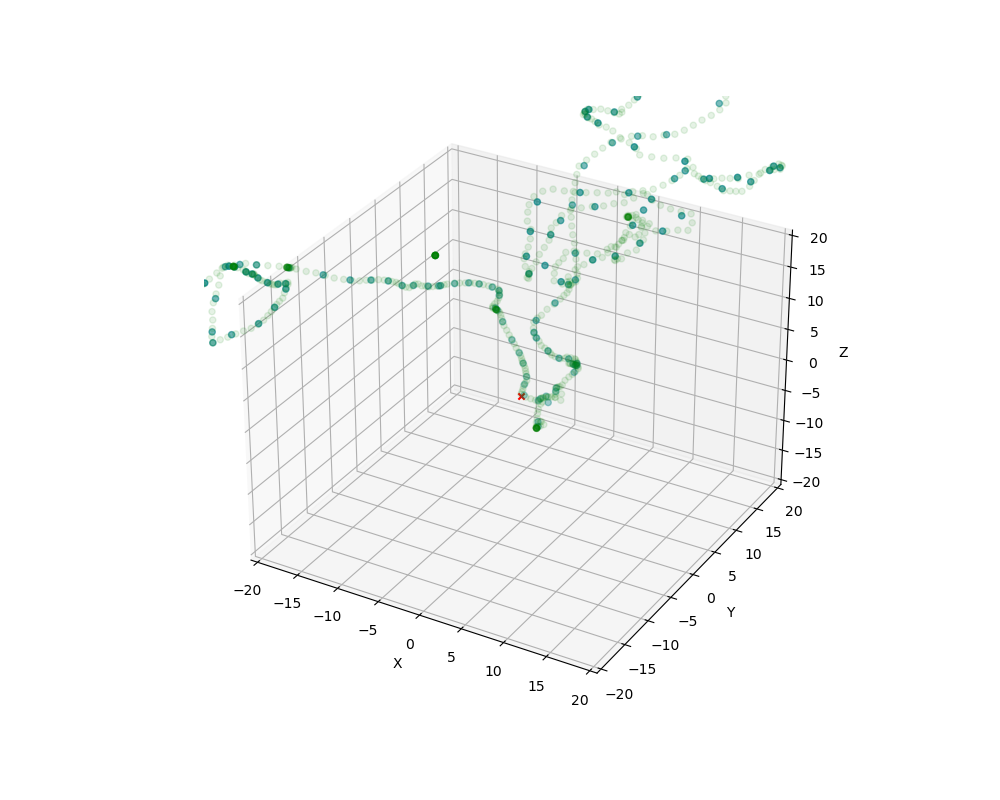

In [216]:
%matplotlib widget

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(hits['x'], hits['y'], hits['z'], marker='o',alpha=0.1,color="DarkOrange")
ax.scatter(0,0,0, marker='x',color="r")
display(df_smear_merge)
ax.scatter(df_smear_merge['x'], df_smear_merge['y'], df_smear_merge['z'], marker='o',color="Teal")
ax.scatter(hits['x'], hits['y'], hits['z'], marker='o',color="g", alpha = 0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_zlim(-20,20)
